このノートブックは上記論文で提案されている量子回路データセットの1つをQBMで再現するものである。  
This notebook reproduces one of the quantum circuit data sets proposed in the above paper by QBM.

---

## Setup

In [1]:
import quimb as qu
import matplotlib.pyplot as plt
import joblib
import numpy as np
from tqdm import tqdm
from quimb.tensor import circuit

from qiskit import Aer
from qiskit.circuit import QuantumCircuit

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# define number of sites == number of qubits (each site is a 2-level system)
n = 8

In [4]:
vqe_data_folder = "../../../VQE-generated-dataset/data"

## Target state

ここでは、論文中のlabel 0のハミルトニアンを対象とする。  
Here, we will focus on the Hamiltonian of label 0 in the paper.  
$\sum_{n=1}^{N-1} Z_n Z_{n+1} + 2 \sum_{n=1}^{N} X_n$ (1D transverse-field Ising model)

In [5]:
joblib.load(f"{vqe_data_folder}/ground_state/{str(n).zfill(2)}qubit/label0.jb")

{'ground_energy': -16.88514149320815,
 'ground_state': array([-0.02532165+0.j,  0.03165327+0.j,  0.0405503 +0.j, -0.0308588 +0.j,
         0.03935861+0.j, -0.0522599 +0.j, -0.03831016+0.j,  0.03106473+0.j,
         0.03964066+0.j, -0.04871257+0.j, -0.06736265+0.j,  0.0505935 +0.j,
        -0.03739069+0.j,  0.04895714+0.j,  0.03889204+0.j, -0.03098128+0.j,
         0.03964066+0.j, -0.04983024+0.j, -0.06239904+0.j,  0.04771403+0.j,
        -0.06544119+0.j,  0.08721343+0.j,  0.06280657+0.j, -0.05117069+0.j,
        -0.03767198+0.j,  0.04652767+0.j,  0.06313219+0.j, -0.04760395+0.j,
         0.03797767+0.j, -0.04997331+0.j, -0.03876997+0.j,  0.03106473+0.j,
         0.03935861+0.j, -0.04909998+0.j, -0.06338813+0.j,  0.04815476+0.j,
        -0.06011404+0.j,  0.07969651+0.j,  0.05881827+0.j, -0.04760395+0.j,
        -0.06544119+0.j,  0.08029561+0.j,  0.11162211+0.j, -0.0837344 +0.j,
         0.06085663+0.j, -0.0795603 +0.j, -0.06362204+0.j,  0.0505935 +0.j,
        -0.03739069+0.j,  0.046915

In [6]:
ground_state = qu.qarray(joblib.load(f"{vqe_data_folder}/ground_state/{str(n).zfill(2)}qubit/label0.jb")["ground_state"].reshape(-1, 1))
ground_state

[[-0.025322+0.j]
 [ 0.031653+0.j]
 [ 0.04055 +0.j]
 [-0.030859+0.j]
 [ 0.039359+0.j]
 [-0.05226 +0.j]
 [-0.03831 +0.j]
 [ 0.031065+0.j]
 [ 0.039641+0.j]
 [-0.048713+0.j]
 [-0.067363+0.j]
 [ 0.050594+0.j]
 [-0.037391+0.j]
 [ 0.048957+0.j]
 [ 0.038892+0.j]
 [-0.030981+0.j]
 [ 0.039641+0.j]
 [-0.04983 +0.j]
 [-0.062399+0.j]
 [ 0.047714+0.j]
 [-0.065441+0.j]
 [ 0.087213+0.j]
 [ 0.062807+0.j]
 [-0.051171+0.j]
 [-0.037672+0.j]
 [ 0.046528+0.j]
 [ 0.063132+0.j]
 [-0.047604+0.j]
 [ 0.037978+0.j]
 [-0.049973+0.j]
 [-0.03877 +0.j]
 [ 0.031065+0.j]
 [ 0.039359+0.j]
 [-0.0491  +0.j]
 [-0.063388+0.j]
 [ 0.048155+0.j]
 [-0.060114+0.j]
 [ 0.079697+0.j]
 [ 0.058818+0.j]
 [-0.047604+0.j]
 [-0.065441+0.j]
 [ 0.080296+0.j]
 [ 0.111622+0.j]
 [-0.083734+0.j]
 [ 0.060857+0.j]
 [-0.07956 +0.j]
 [-0.063622+0.j]
 [ 0.050594+0.j]
 [-0.037391+0.j]
 [ 0.046916+0.j]
 [ 0.059161+0.j]
 [-0.045165+0.j]
 [ 0.060857+0.j]
 [-0.081   +0.j]
 [-0.058658+0.j]
 [ 0.047714+0.j]
 [ 0.037978+0.j]
 [-0.046813+0.j]
 [-0.063964+0.

上記のハミルトニアンの基底状態を別途計算し、一致することを確認する。  
Calculate the ground state of the Hamiltonian above separately and check for agreement.

In [7]:
target_jz = 4  # not 1, because this is the coefficients of spin operators, not pauli operators
target_bx = -4  # not 2, because this is the negative coefficients of spin operators, not pauli operators

In [8]:
# create the Hamiltonian of the TFIM
target_tfim = qu.ham_ising(n, target_jz, target_bx)

In [9]:
# the first eigenvector
eigen_values, eigen_vectors = qu.eigh(target_tfim)
print(eigen_values[0])
print(eigen_vectors[:, [0]])

-16.885141493208163
[[-0.025322]
 [ 0.031653]
 [ 0.04055 ]
 [-0.030859]
 [ 0.039359]
 [-0.05226 ]
 [-0.03831 ]
 [ 0.031065]
 [ 0.039641]
 [-0.048713]
 [-0.067363]
 [ 0.050594]
 [-0.037391]
 [ 0.048957]
 [ 0.038892]
 [-0.030981]
 [ 0.039641]
 [-0.04983 ]
 [-0.062399]
 [ 0.047714]
 [-0.065441]
 [ 0.087213]
 [ 0.062807]
 [-0.051171]
 [-0.037672]
 [ 0.046528]
 [ 0.063132]
 [-0.047604]
 [ 0.037978]
 [-0.049973]
 [-0.03877 ]
 [ 0.031065]
 [ 0.039359]
 [-0.0491  ]
 [-0.063388]
 [ 0.048155]
 [-0.060114]
 [ 0.079697]
 [ 0.058818]
 [-0.047604]
 [-0.065441]
 [ 0.080296]
 [ 0.111622]
 [-0.083734]
 [ 0.060857]
 [-0.07956 ]
 [-0.063622]
 [ 0.050594]
 [-0.037391]
 [ 0.046916]
 [ 0.059161]
 [-0.045165]
 [ 0.060857]
 [-0.081   ]
 [-0.058658]
 [ 0.047714]
 [ 0.037978]
 [-0.046813]
 [-0.063964]
 [ 0.048155]
 [-0.037571]
 [ 0.049349]
 [ 0.038595]
 [-0.030859]
 [ 0.04055 ]
 [-0.050729]
 [-0.064805]
 [ 0.049349]
 [-0.063388]
 [ 0.084215]
 [ 0.061585]
 [-0.049973]
 [-0.062399]
 [ 0.076729]
 [ 0.105875]
 [-0.

固有値、固有ベクトルが一致している。  
今回は、この状態の密度行列を学習対象とする。  
Both eigenvalues and eigenvectors are equal.  
In this notebook, the density matrix of this state is the target.

In [10]:
target_eta = ground_state @ ground_state.H

In [13]:
target_eta

[[ 0.000641+0.j -0.000802+0.j -0.001027+0.j ... -0.001027+0.j -0.000802+0.j  0.000641+0.j]
 [-0.000802+0.j  0.001002+0.j  0.001284+0.j ...  0.001284+0.j  0.001002+0.j -0.000802+0.j]
 [-0.001027+0.j  0.001284+0.j  0.001644+0.j ...  0.001644+0.j  0.001284+0.j -0.001027+0.j]
 ...
 [-0.001027+0.j  0.001284+0.j  0.001644+0.j ...  0.001644+0.j  0.001284+0.j -0.001027+0.j]
 [-0.000802+0.j  0.001002+0.j  0.001284+0.j ...  0.001284+0.j  0.001002+0.j -0.000802+0.j]
 [ 0.000641+0.j -0.000802+0.j -0.001027+0.j ... -0.001027+0.j -0.000802+0.j  0.000641+0.j]]

In [11]:
target_probs = qu.eigvalsh(target_eta)

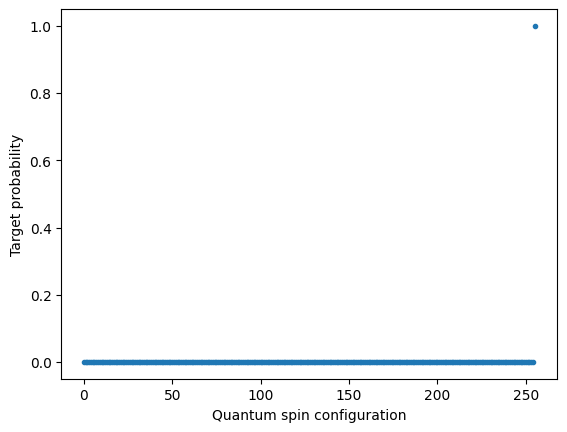

In [12]:
_ = plt.plot(target_probs, '.')
_ = plt.ylabel("Target probability")
_ = plt.xlabel("Quantum spin configuration")

純粋状態なので、1点以外で確率は0である。  
Since this is a pure state, the probability is zero except for one point.

## QBM definition

In [14]:
rng = np.random.default_rng(seed=1)

In [15]:
# parameters to learn. Set initial values at random
jz = rng.normal()
bx = rng.normal()
print(f"Spin interaction: {jz:.3f}")
print(f"Field value: {bx:.3f}")

Spin interaction: 0.346
Field value: 0.822


In [16]:
qbm_tfim = qu.ham_ising(n, jz, bx)

In [17]:
rho_qbm = qu.thermal_state(qbm_tfim, -1.0)

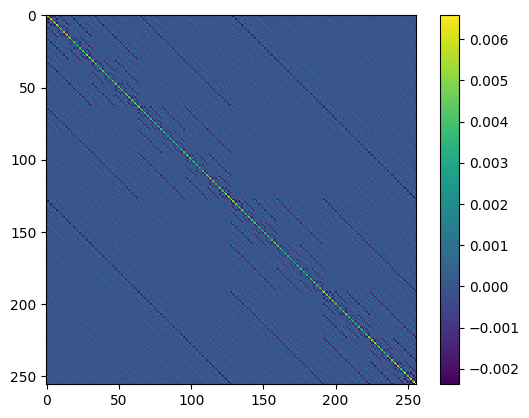

In [18]:
_ = plt.imshow(rho_qbm, interpolation='nearest')
_ = plt.colorbar()

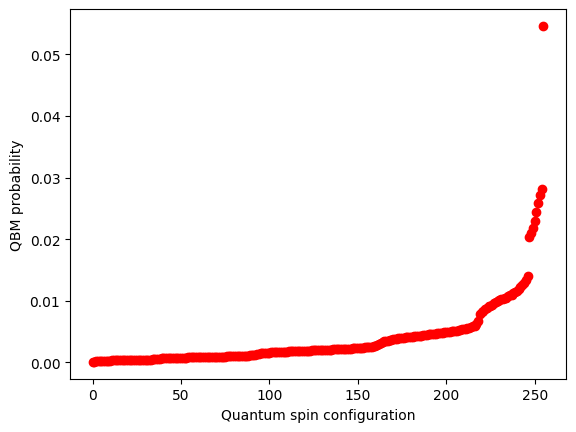

In [19]:
rho_probs = qu.eigvalsh(rho_qbm)
_ = plt.plot(rho_probs,'or')
_ = plt.ylabel("QBM probability")
_ = plt.xlabel("Quantum spin configuration")

## Quantum relative entropy and its gradients

In [20]:
# function to compute the quantum relative entropy between the target density and the QBM
def qre(eta, h_qbm):
    """Quantum relative entropy

    Args:
        eta (Any): Target density matrix
        h_qbm (Any): Hamiltonian of the QBM
    """
    # h = qu.entropy(eta) # do not use because it has log2 inside
    evals = qu.eigvalsh(eta).clip(1e-300)
    h = np.sum(evals * np.log(evals))
    # use log base e all the way
    evals = qu.eigvalsh(h_qbm).clip(1e-300)
    z = np.sum(np.exp(evals))
    eta_stat = qu.expec(eta, h_qbm)
    return h-eta_stat+qu.log(z)

In [22]:
# function to compute the quantum relative entropy between the target density and the QBM
# since we will deal with a pure state later, which has zero eigenvalues and its log goes ton NAN, we implement a fix
def qre2(eta, h_qbm):
    """Quantum relative entropy

    Args:
        eta (Any): Target density matrix
        h_qbm (Any): Hamiltonian of the QBM
    """
    # check if rank<nqubits
    if np.linalg.matrix_rank(eta.A) == 1:
        h = 0
    else:
        evals = qu.eigvalsh(eta)
        h = np.sum(evals * np.log(evals))
    # use log base e all the way
    evals = qu.eigvalsh(h_qbm)
    z = np.sum(np.exp(evals))
    eta_stat = qu.expec(eta, h_qbm)
    return h-eta_stat+qu.log(z)

In [23]:
qre(target_eta, qbm_tfim)

3.4035956289116136

In [24]:
qre2(target_eta, qbm_tfim)

3.279922101418477

In [25]:
# function to create h0 for the TFIM: this is the two-site term
def h_two_sites(n):
    dims = (2,) * n
    two_site_term = qu.kron(qu.spin_operator('z'), qu.spin_operator('z'))
    def gen_term(i):
        return qu.ikron(two_site_term, dims, [i, i + 1])
    return sum(map(gen_term, range(0,n-1)))


# function to create h1 for the TFIM: this is the transverse-fiels term (put the minus sign in front)
def h_single_site(n):
    dims = (2,) * n
    single_site_term = qu.spin_operator('x')
    def gen_term(i):
        return qu.ikron(single_site_term, dims, [i])
    return -sum(map(gen_term, range(0,n)))

In [26]:
h0 = h_two_sites(n)
h1 = h_single_site(n)

In [27]:
h = jz * h0 + bx * h1
np.allclose(qbm_tfim, h)

True

## Training of the QBM

In [28]:
# learning rate
gamma = 0.2
# number of epochs
epochs = 500

In [29]:
def compute_grads(hi, eta, rho):
    """Compute gradients given a list of hamiltonian terms (operators)

    Args:
        hi (List, Tuple): A list of hamiltonian terms
        eta (Any): The target density matrix
        rho (Any): The QBM density matrix

    Returns:
        np.ndarray: The array of the gradients
    """
    grads = []
    for h in hi:
        rho_expect = qu.expec(rho, h).real
        eta_expect = qu.expec(eta, h).real
        grads.append(rho_expect-eta_expect)
    return np.array(grads)

In [30]:
# gradient descent!
def update_params(params, grads, gamma):
    return params - gamma * grads

In [31]:
new_params = [jz, bx]

In [62]:
# stop when gradient is smaller than epsilon, at the final number of epochs
eps = 1e-6
# keep track of loss and gradients
qre_hist = []
grad_hist = []
for i in range(epochs):
    # create qbm hamiltonians
    qbm_tfim = new_params[0] * h0 + new_params[1] * h1
    qbm_tfim = qbm_tfim.real
    qre_hist.append(qre(target_eta, qbm_tfim))
    # create qbm state
    rho = qu.thermal_state(qbm_tfim, -1.0)
    # grad and update
    grads = compute_grads([h0,h1], target_eta, rho)
    grad_hist.append(np.abs(grads))
    new_params = update_params(new_params, grads, gamma)
    # print diagnostic
    if (i % 10)==0:
        print(f"Quantum relative entropy: {qre_hist[-1]}")
        print(f"Max abs gradient: {np.max(grad_hist[-1])}")
    if np.max(grad_hist[-1]) < eps:
        print(f"Max gradient smaller than precision")
        break

Quantum relative entropy: 0.018930281520873393
Max abs gradient: 0.005730837381103859
Quantum relative entropy: 0.0188101436207333
Max abs gradient: 0.005693358900994705
Quantum relative entropy: 0.018691526996185814
Max abs gradient: 0.005656365642142558
Quantum relative entropy: 0.018574402874968143
Max abs gradient: 0.005619848250366877
Quantum relative entropy: 0.018458743207318662
Max abs gradient: 0.00558379761050376
Quantum relative entropy: 0.01834452064328218
Max abs gradient: 0.005548204838823678
Quantum relative entropy: 0.01823170851128708
Max abs gradient: 0.00551306127572071
Quantum relative entropy: 0.018120280796928512
Max abs gradient: 0.00547835847868039
Quantum relative entropy: 0.01801021212232712
Max abs gradient: 0.0054440882155136205
Quantum relative entropy: 0.01790147772831574
Max abs gradient: 0.0054102424578412744
Quantum relative entropy: 0.017794053453719982
Max abs gradient: 0.00537681337482121
Quantum relative entropy: 0.017687915719228897
Max abs gradien

## Plots of diagnostic quantities

Text(0, 0.5, 'quantum relative entropy')

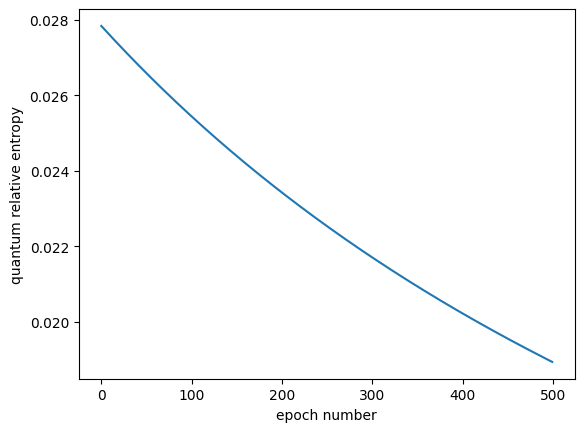

In [52]:
fig, ax = plt.subplots()
ax.plot(qre_hist)
ax.set_xlabel("epoch number")
ax.set_ylabel("quantum relative entropy")

Text(0, 0.5, 'Max. of gradients')

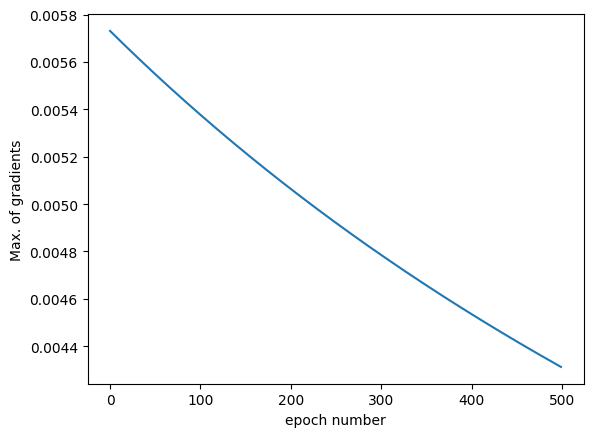

In [63]:
fig, ax = plt.subplots()
ax.plot(np.max(grad_hist,axis=1))
ax.set_xlabel("epoch number")
ax.set_ylabel("Max. of gradients")

KLダイバージェンスや勾配の最大値は0に収束している。  
The relative entropy and the maximum values of gradient are converging toward zero.

## Compare the final parameters with the target parameters.

In [64]:
qbm_tfim = new_params[0] * h0 + new_params[1] * h1
qbm_tfim = qbm_tfim.real
rho_qbm = qu.thermal_state(qbm_tfim, -1.0)

In [65]:
qbm_jz, qbm_bx = -new_params
print(f"Trained QBM parameters:\n Jz={qbm_jz} Bx={qbm_bx}")

Trained QBM parameters:
 Jz=8.26967999556811 Bx=-8.432892421345482


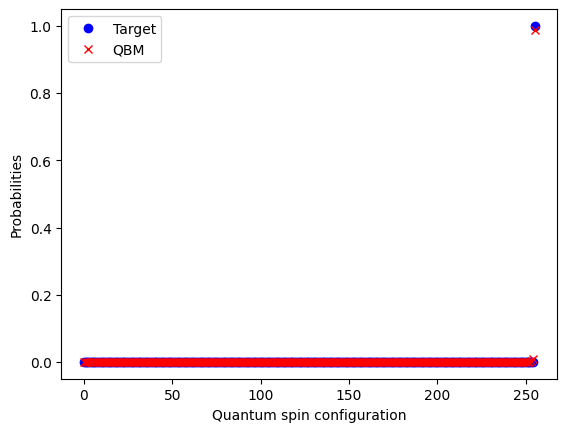

In [66]:
rho_probs = qu.eigvalsh(rho_qbm)
_ = plt.plot(target_probs,'ob')
_ = plt.plot(rho_probs,'xr')
_ = plt.ylabel("Probabilities")
_ = plt.xlabel("Quantum spin configuration")
_ = plt.legend(["Target","QBM"])

QBMで学習された状態と、ターゲット状態およびVQEで生成された量子回路と比較する。  
Compare the state learned in the QBM with the target state and the quantum circuit generated in the VQE.

In [ ]:
circ = QuantumCircuit.from_qasm_file(f"{vqe_data_folder}/qasm/{str(n).zfill(2)}qubit/label0/label0_ansatz0_00.qasm")


In [60]:
circ.draw()

┌───┐┌───────────────┐┌───┐┌────────────────┐»
q_0: ──■─────────────────────■──┤ H ├┤ Rz(-0.031055) ├┤ H ├┤ Rz(-0.0013923) ├»
     ┌─┴─┐┌───────────────┐┌─┴─┐└───┘└───────────────┘└───┘└─────┬───┬──────┘»
q_1: ┤ X ├┤ Rz(-0.031593) ├┤ X ├──■─────────────────────■────────┤ H ├───────»
     └───┘└───────────────┘└───┘┌─┴─┐┌───────────────┐┌─┴─┐      └───┘       »
q_2: ───────────────────────────┤ X ├┤ Rz(-0.071493) ├┤ X ├────────■─────────»
                                └───┘└───────────────┘└───┘      ┌─┴─┐       »
q_3: ────────────────────────────────────────────────────────────┤ X ├───────»
                                                                 └───┘       »
q_4: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_5: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_6: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_7: ────────────────────────────────────────────────────────────────────────»
                                                                             »
«                                                                           »
«q_0: ─────────────────────────────────────────────■────────────────────────»
«      ┌─────────────┐ ┌───┐┌─────────────┐      ┌─┴─┐       ┌─────────────┐»
«q_1: ─┤ Rz(-1.5684) ├─┤ H ├┤ Rz(-1.5614) ├──────┤ X ├───────┤ Rz(-1.2808) ├»
«      └─────────────┘ └───┘└────┬───┬────┘ ┌────┴───┴────┐  └────┬───┬────┘»
«q_2: ───────────────────■───────┤ H ├──────┤ Rz(-1.5707) ├───────┤ H ├─────»
«     ┌───────────────┐┌─┴─┐     └───┘      └─────────────┘       └───┘     »
«q_3: ┤ Rz(-0.077591) ├┤ X ├───────■────────────────────────────────■───────»
«     └───────────────┘└───┘     ┌─┴─┐     ┌────────────────┐     ┌─┴─┐     »
«q_4: ───────────────────────────┤ X ├─────┤ Rz(-0.0081784) ├─────┤ X ├─────»
«                                └───┘     └────────────────┘     └───┘     »
«q_5: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_6: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_7: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«                            ┌───┐      ┌──────────────┐     ┌───┐     »
«q_0: ────────■──────────────┤ H ├──────┤ Rz(-0.24378) ├─────┤ H ├─────»
«           ┌─┴─┐            └───┘      └──────────────┘     └───┘     »
«q_1: ──────┤ X ├──────────────■───────────────────────────────■───────»
«     ┌─────┴───┴─────┐      ┌─┴─┐       ┌────────────┐      ┌─┴─┐     »
«q_2: ┤ Rz(-0.039205) ├──────┤ X ├───────┤ Rz(1.5709) ├──────┤ X ├─────»
«     └─────┬───┬─────┘ ┌────┴───┴────┐  └───┬───┬────┘ ┌────┴───┴────┐»
«q_3: ──────┤ H ├───────┤ Rz(-1.5708) ├──────┤ H ├──────┤ Rz(-1.5708) ├»
«           └───┘       └─────────────┘      └───┘      └────┬───┬────┘»
«q_4: ────────■────────────────────────────────■─────────────┤ H ├─────»
«           ┌─┴─┐      ┌───────────────┐     ┌─┴─┐           └───┘     »
«q_5: ──────┤ X ├──────┤ Rz(-0.052109) ├─────┤ X ├─────────────■───────»
«           └───┘      └───────────────┘     └───┘           ┌─┴─┐     »
«q_6: ───────────────────────────────────────────────────────┤ X ├─────»
«                                                            └───┘     »
«q_7: ─────────────────────────────────────────────────────────────────»
«                                                                      »
«       ┌────────────┐                                                »
«q_0: ──┤ Rz(1.5712) ├────────────────────────────

In [47]:
backend = Aer.get_backend('statevector_simulator')
job = backend.run(circ)
result = job.result()
outputstate = result.get_statevector(circ)

In [48]:
vqe_state = qu.qarray(np.array(outputstate).reshape(-1, 1))

In [67]:
print(qu.fidelity(rho_qbm, target_eta))
print(qu.fidelity(rho_qbm, vqe_state))
print(qu.fidelity(target_eta, vqe_state))

0.993194306581509
0.9929608071323653
0.9997150424313609


学習の結果、ほぼ同じ量子状態となっている。  
この例では、VQEで生成された量子回路の方が、ターゲットの状態に近い。  
The learning results in nearly identical quantum states.  
In this case, the quantum circuit generated by VQE is closer to the target state. 